## Hot Word Detection


In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

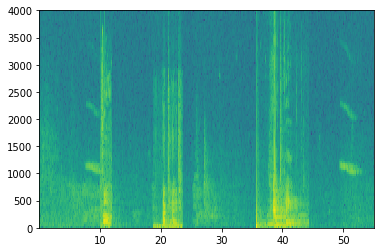

In [2]:
x = graph_spectrogram("audio_examples/example_train.wav")
_, data = wavfile.read("audio_examples/example_train.wav")
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

## Generating a single training example


In [3]:
activates, negatives, backgrounds = load_raw_audio()


In [4]:
def time_random(length_of_segment):

    segment_start = np.random.randint(low=0, high=10000-length_of_segment)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + length_of_segment - 1
    
    return (segment_start, segment_end)

def overlap_check(segment_time, previous_segments):

    segment_start, segment_end = segment_time
    overlap_flag = False
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap_flag = True
    return overlap_flag


def embed_audio(background, audio_clip, previous_segments):
    length_of_segment = len(audio_clip)
    segment_time = time_random(length_of_segment)
    
    while overlap_check(segment_time, previous_segments):
        segment_time = time_random(length_of_segment)

    previous_segments.append(segment_time)
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

def label_timestamps(y, segment_end_ms):
    
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    
    return y


def generate_sample_data(background, activates, negatives):

    np.random.seed(18)
    
    background = background - 20

    y = np.zeros((1, Ty))

    previous_segments = []

    
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    for random_activate in random_activates:
        
        background, segment_time = embed_audio(background, random_activate, previous_segments)
        segment_start, segment_end = segment_time
        y = label_timestamps(y, segment_end_ms=segment_end)

    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    for random_negative in random_negatives:
        background, _ = embed_audio(background, random_negative, previous_segments)
    
    background = match_target_amplitude(background, -20.0)

    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in the directory.")
    
    x = graph_spectrogram("train.wav")
      

    return x, y

File (train.wav) was saved in the directory.


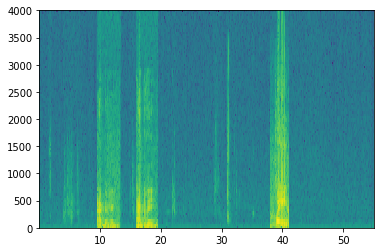

In [5]:
x, y = generate_sample_data(backgrounds[0], activates, negatives)
X = np.load("./XY_train/X.npy")
Y = np.load("./XY_train/Y.npy")

Now we can listen to the training example we created and compare it to the spectrogram generated above.

In [6]:
IPython.display.Audio("train.wav")

In [7]:
X_dev = np.load("./XY_dev/X_dev.npy")
Y_dev = np.load("./XY_dev/Y_dev.npy")

# Model


In [8]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape,CuDNNLSTM,CuDNNGRU, LSTM
from keras.optimizers import Adam

Using TensorFlow backend.
/home/mohit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohit/anaconda3/lib/python3.7/site-packages/tensorflo

# Build the model


In [9]:
def model(input_shape):

    X_input = Input(shape = input_shape)
    
    
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)                                 
    X = Activation('relu')(X)                                 
    X = Dropout(0.9)(X)
    

    X = GRU(units = 128, return_sequences = True)(X) 
    X = Dropout(0.9)(X) 
    
    X = LSTM(units = 128, return_sequences = True)(X)                           
    X = Dropout(0.9)(X)
    
    X = Dense(64)(X)
    X = Activation('relu')(X)
    X = Dropout(0.9)(X)
     
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [10]:
model = model(input_shape = (Tx, n_freq))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1375, 128)         0         
_______________________

## Fit the model

In [11]:
model = load_model('./models/tr_model.h5')
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["binary_accuracy"])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/mohit/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
model.fit(X, Y, batch_size = 5, epochs=10)

Epoch 1/10
10/26 [==========>...................] - ETA: 19s - loss: 0.0361 - binary_accuracy: 0.9884

## Test the model



In [ ]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

# Making Predictions


In [ ]:
def detect_hotword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions_at_each_timestamp = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions_at_each_timestamp[0,:,0])
    plt.ylabel('probability')
    plt.show()
    
    return predictions_at_each_timestamp

In [ ]:
hello_file = "audio_examples/hello.wav"
def hello_on_activate(filename, predictions_at_each_timestamp, threshold):
    
    speech_recording = AudioSegment.from_wav(filename)
    hello = AudioSegment.from_wav(hello_file)
    Ty = predictions_at_each_timestamp.shape[1]
    consecutive_timesteps = 0
    for i in range(Ty):
        consecutive_timesteps += 1
        if predictions_at_each_timestamp[0,i,0] > threshold and consecutive_timesteps > 100:
            speech_recording = speech_recording.overlay(hello, position = ((i / Ty) * speech_recording.duration_seconds)*1000)
            consecutive_timesteps = 0
        
    speech_recording.export("hello_output.wav", format='wav')
    
hello_threshold = 0.5


## 3.3 - Test on dev examples

Now lets run the model on these audio clips and see if it adds a hello after "activate"!

In [ ]:
filename = "./raw_data/dev/1.wav"
prediction = detect_hotword(filename)
hello_on_activate(filename, prediction, hello_threshold)
IPython.display.Audio("./hello_output.wav")

In [ ]:
filename  = "./raw_data/dev/2.wav"
prediction = detect_hotword(filename)
hello_on_activate(filename, prediction, hello_threshold)
IPython.display.Audio("./hello_output.wav")

# 4 - Try our own example!

We Recorded a 10 second audio clip saying the word "activate" and other random words.


In [ ]:
def preprocess_audio(filename):
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    segment = segment.set_frame_rate(44100)
    segment.export(filename, format='wav')

Once we've uploaded our audio file, put the path to the file in the variable below.

In [ ]:
our_filename = "audio_examples/my_audio.wav"

In [ ]:
preprocess_audio(our_filename)
IPython.display.Audio(our_filename) 

Finally, use the model to predict when we say activate in the 10 second audio clip, and trigger a hello. 

In [ ]:
prediction = detect_hotword(our_filename)
hello_on_activate(our_filename, prediction, hello_threshold)
IPython.display.Audio("./hello_output.wav")